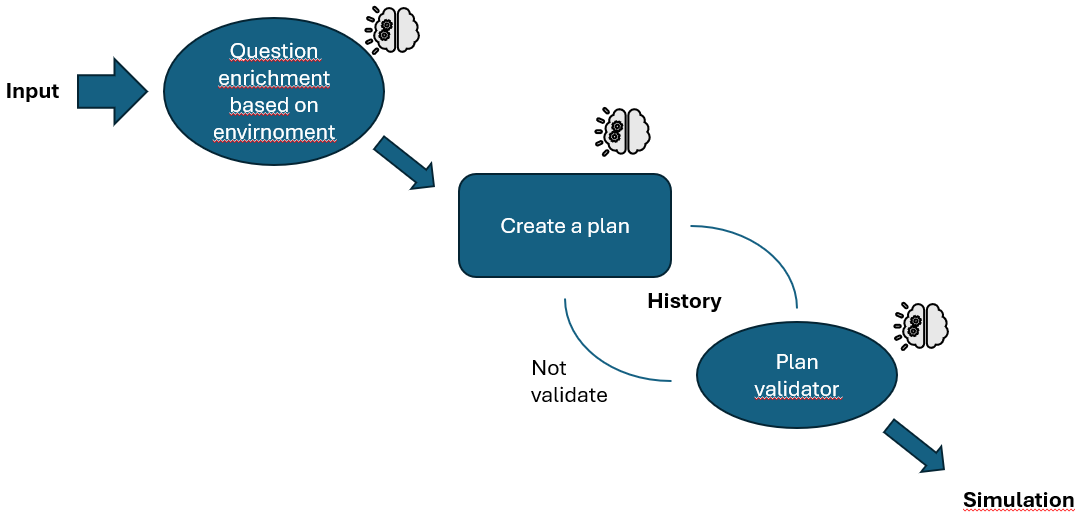

In [1]:
import pandas as pd
import os 
import yaml 
import numpy as np
from tqdm import tqdm 
import ast 
from tqdm import tqdm

In [2]:
from langchain_core.prompts import (  ## prompt and messages templates
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    AIMessagePromptTemplate,
    ChatPromptTemplate,
    MessagesPlaceholder,
    )
from langchain.memory import (
    ConversationBufferMemory,
    ConversationBufferWindowMemory,
    ChatMessageHistory,
    ConversationSummaryBufferMemory,
    ConversationSummaryMemory,
    ConversationTokenBufferMemory,
)
from langchain_core.output_parsers import (  ## output parsers
    JsonOutputParser,
    ListOutputParser,
    PydanticOutputParser,
    StrOutputParser , # parse top likely string.
    )

from langchain_openai import AzureChatOpenAI,AzureOpenAIEmbeddings, ChatOpenAI, OpenAI, OpenAIEmbeddings
from langchain.chains.llm import LLMChain
from dotenv import load_dotenv
load_dotenv(".env.local")

True

## Question enrichment based on environment

In [3]:
format_message = """
{
  'plan' : [ {....}],
}"""

example_message = """
user : create a reversed U 
assistant : { 'plan' : [{'reasoning' : 'rotate of 90° to go upwards with an angular speed on 45  degree/s for 2.0 second.','frontal_speed' : 0.0,'rotation' : 45.0,'time' : 2.0 },{'reasoning' : 'go forward at 1 m/s for 2 second to have a line of 2 m','frontal_speed' : 1.0,'rotation' : 0.0,'time' : 2.0},{'reasoning' : 'To create the curve of the U i to rotate of 90° clockwise maintaining a linear speed of 1 m/s for at least 2 second','frontal_speed' : 1.0,'rotation' : -90.0,'time' : 2.0 },{ 'reasoning' :  'to reach the goal go forward for 1 s at 2 m/s','frontal_speed' : 2.0,'rotation' : 0.0,'time' : 1.0}]}
"""

In [4]:
questions = ["il robot deve creare una un rettangolo di X=3 m e Y=2 m", "il robot deve creare quadrato di lunghezza 2 metri",
              "il robot deve creare un triangolo equilatero" , "il robot deve creare un cerchio di raggio 1 metro","il robot deve raggiungere il punto (x=2.5, y=9.0)"]
yaml_path = os.path.join(os.getcwd(), "prompts", "phase1_step4" )
with open(os.path.join(yaml_path, "create_plan.yaml"), "r") as file:
    plan_creator = yaml.safe_load(file)
with open(os.path.join(yaml_path, "validator_plan.yaml"), "r") as file:
    validator_plan = yaml.safe_load(file)

llm = ChatOpenAI(model = os.getenv("OPENAI_MODEL"), seed = 42)

c:\Users\giobo\Documents\Libreria_personale\Utilities_library\.venv_lib\Lib\site-packages\langchain_core\utils\utils.py:159: UserWarning: WARNING! seed is not default parameter.
                seed was transferred to model_kwargs.
                Please confirm that seed is what you intended.
  warnings.warn(


In [5]:
conversation_memory = ConversationBufferMemory(memory_key='conversation_memory', return_messages=True)
plan_creator_prompt = ChatPromptTemplate.from_messages(messages=[
SystemMessagePromptTemplate.from_template(f"{plan_creator['system_prompt']}").format(format = format_message, example = example_message),
MessagesPlaceholder(variable_name='conversation_memory'),
HumanMessagePromptTemplate.from_template("{input}"),
])

validator_plan_prompt = ChatPromptTemplate.from_messages(messages=[
    SystemMessagePromptTemplate.from_template(f"{validator_plan['system_prompt']}"),
    HumanMessagePromptTemplate.from_template("This is the sequence of action to solve the task : {input}"),
])




validator_chain = LLMChain(
    llm= llm,
    prompt=validator_plan_prompt,
    output_parser=StrOutputParser(), 
    output_key='output',
    verbose=True)
generator_chain = LLMChain(
    llm= llm,
    prompt=plan_creator_prompt,
    output_parser=StrOutputParser(), 
    output_key='output',
    memory=conversation_memory,
    verbose=True)



In [6]:
mode = "w"
for sheet in range(3):
    lines = list()
    df = pd.DataFrame()
    for user_input in tqdm(questions[:1]):
        conversation_memory = ConversationBufferMemory(memory_key='conversation_memory', return_messages=True)
        generator_chain = LLMChain(
            llm= llm,
            prompt=plan_creator_prompt,
            output_parser=StrOutputParser(), 
            output_key='output',
            memory=conversation_memory,
            verbose=True)
        question = user_input
        for i in range(3):
            ## limit the number of attempts   
            try : 
                plan = generator_chain.invoke({"input" : question})
                plan = ast.literal_eval(plan['output'])
                validation = validator_chain.invoke({"input" : str(plan), "original_task" : user_input})
                print(validation['output'])
                valid = ast.literal_eval(validation['output'].replace("false", "False").replace("true", "True"))['valid']
                if valid:
                    print("Plan is valid")
                    break
                else :
                    question = ast.literal_eval(validation['output'].replace("false", "False").replace("true", "True"))['feedback']
            except Exception as e:
                print(e)
        lines.append({"user_input" : user_input, "plan" : plan, "validation" : validation['output'], "attempts" : i , "valid" : valid})
    with pd.ExcelWriter(os.path.join(os.getcwd(), "results", "phase1_res_step4_second", f"results_generator_validator.xlsx"), mode=mode) as writer : 
        df = pd.DataFrame(lines)
        df.to_excel(writer, sheet_name=f"experiment_{sheet}", index=False)
        mode = "a"

  0%|          | 0/1 [00:00<?, ?it/s]



> Entering new LLMChain chain...
Prompt after formatting:
System:  As an expert in robotics programming, your task is to create a sequence of commands to control the trajectory of a robot simulation, based on the following requirements: The field is a square measuring 11.0 meters in both the x and y directions. The robot's starting point is at x=0 and y=0, with the head oriented along the positive x-axis (forward direction). The X-axis increases from left to right, and the Y-axis increases from bottom to top. Pay attention that the robot MUST not exceed the square field.
Each JSON object in the sequence should contain the following fields: - reasoning: reason behind the movement, ALWAYS specify the starting (x,y) and ending point (x,y) but also the orientation of the robot (which axis is parallel to the robot's head) - frontal_speed: speed of forward movement, in m/s - rotation: anti-clockwise rotation, in degrees per second (maintain the same coordinate, but changing the orientation

100%|██████████| 1/1 [01:10<00:00, 70.01s/it]


> Finished chain.
{
    "valid": false,
    "feedback": "The sequence of commands is not valid. Here are the errors: \n1. The rotation of 15 degrees in the second command is incorrect. The robot should rotate 90 degrees to align with the positive y-axis. \n2. The rotation of -30 degrees in the fourth command is incorrect. The robot should rotate 90 degrees to align with the negative x-axis. \n3. The rotation of -30 degrees in the sixth command is incorrect. The robot should rotate 90 degrees to align with the negative y-axis. \nPlease correct the rotation angles to achieve the desired trajectory."
}


OSError: Cannot save file into a non-existent directory: 'c:\Users\giobo\Documents\Magistrale_2anno\Tesi\LLM_for_robotics_thesis\results\phase1_res_step4_second'